In [172]:
import numpy as np
import matplotlib.pyplot as plt

#Example done in class using Rule of Mixture and HT Method
#Data given:
S3 = 0.2
S12 = 1
WFibre = 0.6 #Fibre weight Fraction
thickness = 0.000125 #m For each Layer (Question 5)

# Laminate Configuration for Question 1
laminate_config = [90, 45,-45, 0] # (Question 5)
nLayers = len(laminate_config)

print(f'\nThe laminate configuration for this laminate is: {laminate_config}')
print(f'The thickness of the laminate is: {nLayers*thickness} m or {nLayers*thickness*1e3} mm, each laminate in the configuration has the same thickness, thus: {thickness} m')

# Calculating the bottom and top thickness of the laminate
position = [-nLayers * thickness / 2 + i * thickness for i in range(nLayers + 1)]
print(f'The position of each layer is {position}')

# Creating an empty list to store Qbar, A1, B1, D1 matrices for each angle
Qbar_list = []
T_list = []
A1_list = []
B1_list = []
D1_list = []

# Use a loop to keep track of the current layer
for i in range(nLayers):  
    angle = laminate_config[i] # Changing index/angle for every loop iteration
    theta = angle * (np.pi / 180)  # Calculate theta based on the angle converted 

    # Question 5 - Material Properties
    E1 = 54 #GPa
    E2 = 18 #GPa
    v12 = 0.28
    v21 = v12 *(E2/E1)  # Minor Poisson Ration
    G12 = 6 #GPa
    
    # Qmatrix
    Q11 = E1 / (1 - v12 * v21)
    Q22 = E2 / (1 - v12 * v21)
    Q12 = v12 * E2 / (1 - v12 * v21)
    Q66 = G12
    Q = np.array([[Q11, Q12, 0],
                [Q12, Q22, 0],
                [0, 0, Q66]])
    # Q = np.round(Q, 3)
    # print(f'\n Q in GN/m^2: \n{Q}')

    # Tmatrix
    T11 = np.cos(theta) ** 2
    T12 = np.sin(theta) ** 2
    T13 = 2 * np.sin(theta) * np.cos(theta)
    T21 = np.sin(theta) ** 2
    T22 = np.cos(theta) ** 2
    T23 = -2 * np.sin(theta) * np.cos(theta)
    T31 = -np.sin(theta) * np.cos(theta)
    T32 = np.sin(theta) * np.cos(theta)
    T33 = np.cos(theta) ** 2 - np.sin(theta) ** 2

    T = np.array([[T11, T12, T13],
                [T21, T22, T23],
                [T31, T32, T33]]) 
    
    T_list.append(T)

    # Inverse of T matrix
    T_inv = np.linalg.inv(T)

    # Transpose of the inverse matrix
    T_inv_transpose = np.transpose(T_inv)

    # Qbar Matrix calculate dot product with T_Inv, Q, T_inv_transpose
    Qbar = T_inv @ Q @ T_inv_transpose
    # Qbar = np.round(Qbar, 3)

    # Converting the NumPy array to a regular Python list
    # Qbar_list.append(Qbar.tolist())
    Qbar_list.append(Qbar)

    # A Matrix
    A1 = Qbar * (position[i + 1] - position[i])
    A1_list.append(A1)

    # B Matrix    
    B1 = (1/2)*Qbar * ((position[i + 1]**2) - (position[i]**2))
    B1_list.append(B1)
    
    # D Matrix    
    D1 = (1/3)*Qbar * ((position[i + 1]**3) - (position[i]**3))
    D1_list.append(D1)

print('\n Using HALPIN-TSAI:')
print(f"E11 is: {E1} N/m^2")
print(f"E22 is: {E2} N/m^2")
print(f"v12 is: {v12}")
print(f"v21 is: {v21}")
print(f"G12 is: {G12} N/m^2 \n")

# Set numpy print options to display numbers without scientific notation, NOT ROUNDING
np.set_printoptions(suppress=True, formatter={'float': lambda x: '0' if x == 0.0 else '{:0.8f}'.format(x)})
    
# Defining one single A, B, D matrix for the laminate (through summing A, B, D for each lamina)
A = np.sum(A1_list, axis=0)
B = np.sum(B1_list, axis=0)
D = np.sum(D1_list, axis=0)

# Concatenating the A, B, and D matrices in the specified order
ABBD = np.block([[A, B], [B, D]])

# Inverse of ABBD Matrix
ABBD_inv = np.linalg.inv(ABBD)



The laminate configuration for this laminate is: [90, 45, -45, 0]
The thickness of the laminate is: 0.0005 m or 0.5 mm, each laminate in the configuration has the same thickness, thus: 0.000125 m
The position of each layer is [-0.00025, -0.000125, 0.0, 0.000125, 0.00025]

 Using HALPIN-TSAI:
E11 is: 54 N/m^2
E22 is: 18 N/m^2
v12 is: 0.28
v21 is: 0.09333333333333334
G12 is: 6 N/m^2 



In [188]:
# Define the different directions
Nx = 25000
Ny = 0
Nxy = 0
Mx = 0
My = 0
Mxy = 0

NM = np.array([[Nx], [Ny], [Nxy], [Mx], [My], [Mxy]])

result = np.dot(np.linalg.inv(ABBD*1e9), NM) # Calculate the strain in different directions -> [ϵx, ϵy, γxy, κx, κy, κxy] vector
ex, ey, yxy, kx, ky, kxy = result # Assigning each strain to its value in the result matrix
print(result)




[[0.00204974]
 [-0.00066543]
 [-0.00014386]
 [-4.69045619]
 [-0.76308522]
 [2.65164503]]


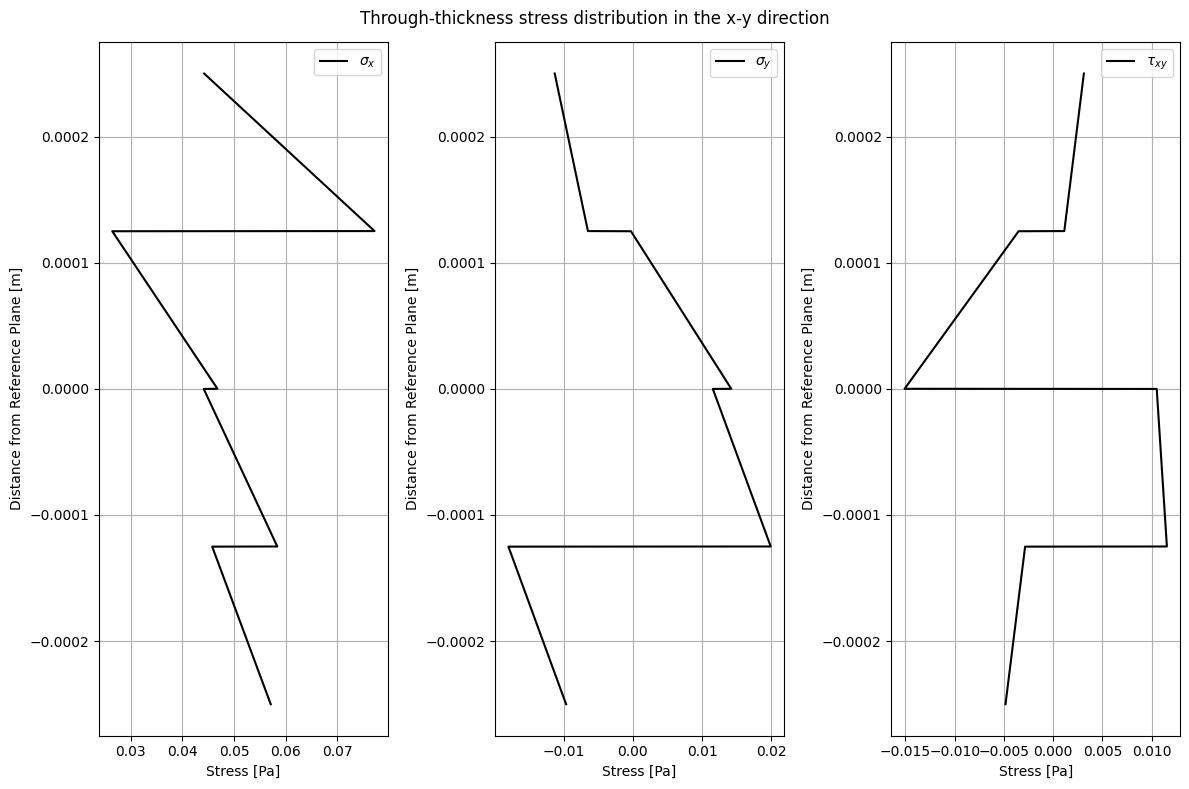

In [194]:
# Calculations for Stress Plots (x-y coordinates)
# Split strains and curvatures
e_o = np.array([ex, ey, yxy]) # Strain
k_o = np.array([kx, ky, kxy]) # Curvature 

sigmax = [] # Storing Stresses in the X direction
sigmay = [] # Storing Stresses in the Y direction
tauxy = [] # Storing Stresses in the XY direction

divisions = 1e3

for i in range(len(laminate_config)):  # Loop through each ply
    for k in np.arange(0, position[-2], position[-2]/divisions):
        z = position[i] + k
        strain = e_o + z * k_o
        temp_stress = np.dot(Qbar_list[i], strain)  # [z[i] + k]*[Qbar]
        sigmax.append(temp_stress[0])
        sigmay.append(temp_stress[1])
        tauxy.append(temp_stress[2])
        
distance = np.linspace(position[0], position[-1], len(sigmax))

#Plotting the Graph
fig, axs = plt.subplots(1, 3, figsize=(12, 8))
fig.suptitle('Through-thickness stress distribution in the x-y direction')
axs[0].plot(sigmax, distance, label=r'$\sigma_{x}$', color='black')
axs[1].plot(sigmay, distance, label=r'$\sigma_{y}$', color='black')
axs[2].plot(tauxy, distance, label=r'$\tau_{xy}$', color='black')
for ax in axs.flat:
    ax.grid(True)
    ax.set_xlabel('Stress [Pa]')
    ax.set_ylabel('Distance from Reference Plane [m]')
    ax.legend()
    
plt.tight_layout()
plt.show()

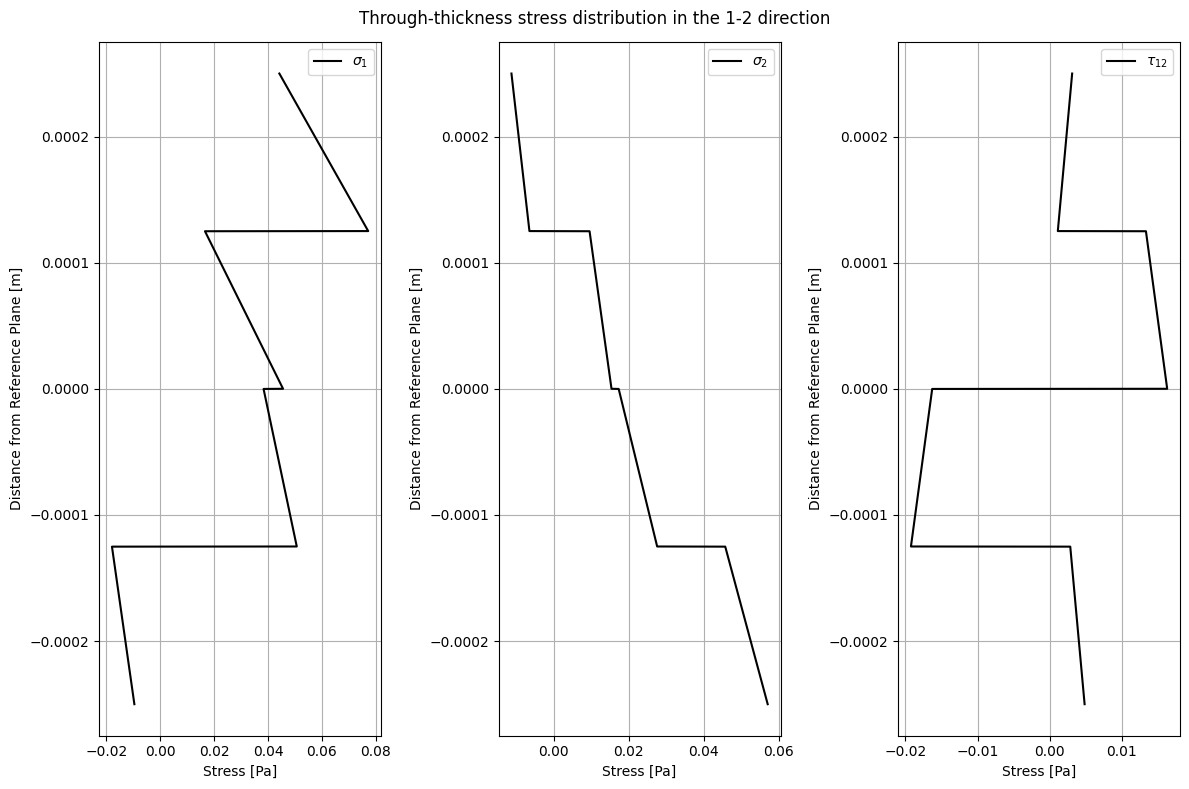

In [196]:
#Stresses List in 1-2 Direction
sigma1 = []
sigma2 = []
tau12 = [] 
eps1 = []
eps2 = []
gamma12 = [] 

for i in range(len(laminate_config)):  # Loop through each ply
    for k in np.arange(0, position[-2], position[-2]/divisions):
        z = position[i] + k
        strain = e_o + z * k_o
        temp_stress = np.dot(Qbar_list[i], strain)  # [z[i] + k]*[Qbar]
        strain12 = np.dot(T_list[i], strain)
        
        eps1.append(strain12[0])
        eps2.append(strain12[1])
        gamma12.append(strain12[2])
        
        transformed_stress = np.dot(T_list[i], temp_stress)    # Temporary stress transformed back to 12 coordinates
        sigma1.append(transformed_stress[0])
        sigma2.append(transformed_stress[1])
        tau12.append(transformed_stress[2])

#Plotting the Graph
fig, axs = plt.subplots(1, 3, figsize=(12, 8))
fig.suptitle('Through-thickness stress distribution in the 1-2 direction')
axs[0].plot(sigma1, distance, label=r'$\sigma_{1}$', color='black')
axs[1].plot(sigma2, distance, label=r'$\sigma_{2}$', color='black')
axs[2].plot(tau12, distance, label=r'$\tau_{12}$', color='black')
for ax in axs.flat:
    ax.grid(True)
    ax.set_xlabel('Stress [Pa]')
    ax.set_ylabel('Distance from Reference Plane [m]')
    ax.legend()
    
plt.tight_layout()
plt.show()

In [221]:
Xt = 1040*1e-3 #GPa longitudinal strength in tension
Yt = 35*1e-3 #GPa longitudinal strength in compression
Xc = 570*1e-3 #GPa transverse strength in tension
Yc = 114*1e-3 #GPa transverse strength in compression
S = 72*1e-3 #GPa shear strength
eps1t = 0.021
eps2t = 0.002
eps1c = 0.011
eps2c = 0.0064
gamma6 = 0.038

fibreLayer = [0, divisions, divisions+1, (2*divisions)+1, (2*divisions)+2, (3*divisions)+2, (3*divisions)+3, (4*divisions)+3] # [0, 1000, 1001, 2001, 2002, 3002, 3003, 4003]

s1 = [sigma1[int(i)] for i in fibreLayer] # [sigma1[0], sigma1[1000], sigma1[1001], sigma1[2001], sigma1[2002], sigma1[3002], sigma1[3003], sigma1[4003]]
s2 = [sigma2[int(i)] for i in fibreLayer]
t12 = [tau12[int(i)] for i in fibreLayer]
e1 = [eps1[int(i)] for i in fibreLayer]
e2 = [eps2[int(i)] for i in fibreLayer]
g12 = [gamma12[int(i)] for i in fibreLayer]

# Max Stress
print('Max Strain Method')
for i in range(len(s1)):
    if s1[i] >= Xt:
        print('The laminate failed in parallel tension at ply interface', i)
        safety_factor = Xt/s1[i]
        failure_load = safety_factor*NM[0]
        print('The failure load is', failure_load, 'N/m')
    elif s2[i] >= Yt:
        print('The laminate failed in transverse tension at ply interface', i)
        safety_factor = Yt/s2[i]
        failure_load = safety_factor*NM[0]
        print('The failure load is', failure_load, 'N/m')
    elif s1[i] <= Xc:
        print('The laminate failed in Parallel compression at ply interface', i)
        safety_factor = Xc/s1[i]
        failure_load = safety_factor*NM[0]
        print('The failure load is', failure_load, 'N/m')
    elif s2[i] <= Yc:
        print('The laminate failed in transverse compression at ply interface', i)
        safety_factor = Yc/s2[i]
        failure_load = safety_factor*NM[0]
        print('The failure load is', failure_load, 'N/m')
    elif abs(t12[i]) >= S:
        print('The laminate failed in transverse compression at ply interface', i)
        safety_factor = S/abs(t12[i])
        failure_load = safety_factor*NM[0]
        print('The failure load is', failure_load, 'N/m')
    else:
        print('The laminate did not fail')


print('\nMax Strain Method')
for i in range(len(e1)):
    
    if e1[i] >= eps1t:
        print('The laminate failed in parallel tension at ply interface', i)
        safety_factor = eps1t/e1[i]
        failure_load = safety_factor*NM[0]
        print('The failure load is', failure_load, 'N/m')
    elif e2[i] >= eps2t:
        print('The laminate failed in transverse tension at ply interface', i)
        safety_factor = eps2t/e2[i]
        failure_load = safety_factor*NM[0]
        print('The failure load is', failure_load, 'N/m')
    elif e1[i] <= eps1c:
        print('The laminate failed in Parallel compression at ply interface', i)
        safety_factor = eps1c/e1[i]
        failure_load = safety_factor*NM[0]
        print('The failure load is', failure_load, 'N/m')
    elif e2[i] <= eps2c:
        print('The laminate failed in transverse compression at ply interface', i)
        safety_factor = eps2c/e2[i]
        failure_load = safety_factor*NM[0]
        print('The failure load is', failure_load, 'N/m')
    elif abs(g12[i]) >= gamma6:
        print('The laminate failed in transverse compression at ply interface', i)
        safety_factor = gamma6/abs(g12[i])
        failure_load = safety_factor*NM[0]
        print('The failure load is', failure_load, 'N/m')
    else:
        print('The laminate did not fail')

Max Strain Method
The laminate failed in transverse tension at ply interface 0
The failure load is [15323.33290905] N/m
The laminate failed in transverse tension at ply interface 1
The failure load is [19116.45316290] N/m
The laminate failed in Parallel compression at ply interface 2
The failure load is [281191.89246401] N/m
The laminate failed in Parallel compression at ply interface 3
The failure load is [371622.81298728] N/m
The laminate failed in Parallel compression at ply interface 4
The failure load is [312651.74092529] N/m
The laminate failed in Parallel compression at ply interface 5
The failure load is [859338.52352145] N/m
The laminate failed in Parallel compression at ply interface 6
The failure load is [184564.33671138] N/m
The laminate failed in Parallel compression at ply interface 7
The failure load is [322361.53363109] N/m

Max Strain Method
The laminate failed in transverse tension at ply interface 0
The failure load is [15516.58442682] N/m
The laminate failed in tran